# Задание

Дана следующая задача: $(x−μ)^⊤A(x−μ) \to min$

При ограничении Евклидовой нормой: $∥x∥^2_2=∥x∥^2≤1$, что эквивалентно $(\sqrt{\sum_{i=1}^{n}|x_i|^2})^2=\sum_{i=1}^{n}x_i^2=x_1^2+...+x_n^2 ≤ 1$

Где: где $x∈R^n$, $A$ - симметричная, положительно определенная матрица, $μ = (1, 1, . . . , 1)^⊤ ∈ R^n$.
1) Записать ***двойственную к ней задачу*** и применить метод из Лабораторной работы #1 к двойственной задаче.
2) Для метода из Лабораторной работы #1 замените градиент на ***стохастический градиент*** (шаг нужно выбирать тем же способом, как и в обычном градиентном спуске): <br>
    $\widetilde{∇}f(x)=\frac{1}{m}\sum_{j=1}^{m}(0, 0, ..., 0, nf'_{x_i}, 0, ..., 0)^T$, где $i$ выбирается случайным образом от 1 до n.<br>
И применить метод стохастического градиентного спуска ***для различных значений параметра*** $m ∈ \{1, \frac{n}{8} , \frac{n}{4} , \frac{n}{2} , n\}$.
3) Представить следующие результаты:
    * Для заданной точности $ε > 0$ **по значению целевой функции** и для каждого значения размерности $n ∈ \{10, 20, ..., 100\}$ и $m ∈ \{1, \frac{n}{8} , \frac{n}{4} , \frac{n}{2} , n\}$ подсчитайте ***среднее число арифметических операций*** для обычного и стохастического градиентного спуска в прямой задаче и в двойственной (стохастический метод для двойственной задачи в данном случае аналогичен прямому методу), усреднение проводится по всем начальным точкам P и по всем тестовым примерам N. Если число операций подсчитать не удается, то указать среднее время работы метода. Какой метод работает лучше и почему?
    * Для одного тестового примера при $n = 10$ и нескольких различных начальных точек постройте ***зависимость точности от числа арифметических операций*** в методах градиентного и стохастического градиентного спуска, примененных для прямой задачи. Если число операций подсчитать не получается, то построить зависимость средней точности от времени работы метода.

Для размерностей больше 40 <span style="color:red">время подсчёта становится слишком большим</span>, особенно в стохастическом спуске прямой задачи, поэтому ограничусь рассмотрением размерностей до 50 включительно.

# Настройки/Импорты

Версии важных модулей:
* cvxpy==1.4.3
* numpy==1.23.0

In [1]:
import cvxpy as cp # солвер для задач
import numpy as np # для работы с массивами
from sklearn.datasets import make_spd_matrix # для генерации симметричной положительно определённой матрицы A для поставленной задачи

import time # для отслеживания времени выполнения
from tqdm import tqdm # для отслеживания прогресса
from matplotlib import pyplot as plt # для построения графиков/вывода изображений

In [2]:
n = np.arange(10, 41, 10) # возможные значения n (число переменных в задаче ~ размерность пространства) от 10 до 40 включительно
N = 10 # число тестовых примеров для каждого значения n
P = 5 # число начальных точек для каждого примера N
ε = 0.1 # необходимая точность

DIM = 10 # интересующая нас размерность пространства, на которой будут проходить тесты

# Вспомогательные функции

In [3]:
def func_primal(x: np.array, A: np.array, μ: np.array) -> np.float32:
    """
    Прямая функция из задачи.\n
    Parameters:
        * x: текущие значения x (в виде столбца)
        * A: матрица A
        * μ: смещение центра функции (в виде столбца)\n
    Returns:
        * np.float32: значение функции в точке x
    """
    return ((x-μ).T @ A @ (x-μ))[0] # значение функции задачи (было бы (x-μ) @ A @ (x-μ).reshape((dim,1)), если бы x шёл как строка, а не столбец) ([0] — из-за вложенности)

In [4]:
def func_primal_grad(x: np.array, A: np.array, μ: np.array) -> np.array:
    """
    Производная прямой функции из задачи.\n
    Parameters:
        * x: текущие значения x (в виде вектора-столбца)
        * A: матрица A
        * μ: смещение центра функции (в виде вектора-столбца)\n
    Returns:
        * np.array: вектор-столбец градиента функции в точке x
    """
    return 2 * A @ (x - μ) # значение производной функции задачи
    # return 2 * A @ x # значение производной функции задачи

In [5]:
def constraints_primal(x: np.array) -> bool:
    """
    Функция для проверка решения прямой задачи на допустимость.\n
    Parameters:
        * x: текущие значения x (в виде вектора-столбца)\n
    Returns:
        * bool: True — если решение допустимо, иначе — False
    """
    return np.linalg.norm(x, ord=2) ** 2 <= 1 # квадрат евклидовой нормы решения должен быть ≤ 1

In [6]:
def constraints_primal_grad(x: np.array) -> np.array:
    """
    Производная функции ограничения из задачи.\n
    Parameters:
        * x: текущие значения x (в виде вектора-столбца)\n
    Returns:
        * np.array: значение производной функции ограничения в точке x
    """
    return 2 * x 

In [7]:
def optimal(x: np.array, A: np.array, μ: np.array) -> bool:
    """
    Функция для проверки оптимальности решения прямой задачи. Необходимо, чтобы вектора градиента к ограничению и антиградиента к целевой функции были сонаправлены. 
    Для проверки сонаправленности необходимо, чтобы вектора были коллинеарны (x1/y1 = x2/y2 = ... = xn/yn) и их скалярное произведение (dot product) было положительным.\n
    Parameters:
        * x: текущие значения x (в виде вектора-столбца)
        * A: матрица A
        * μ: смещение центра функции (в виде вектора-столбца)\n
    Returns:
        * bool: True — если решение оптимально, False — иначе
    """
    grad_const = constraints_primal_grad(x) # значение вектора градиента ограничений
    grad_func = func_primal_grad(x, A, μ) # значение вектора градиента функции

    # relation = grad_const / grad_func # отношение (x1/y1, x2/y2, ..., xn/yn) для проверки коллинеарности 
    # assert np.isclose(relation, relation[0], atol=0.1).all(), "Вектора не коллинеарны!" # если не все значения (x1/y1, x2/y2, ..., xn/yn) совпадают с точностью до atol — выкидываем ошибку

    return grad_const.T @ -grad_func > 0 # проверка сонаправленнсоти (скалярное произведение вектора градиента к ограничению и антиградиента к целевой функции положительно)

In [8]:
def dist(x_1: np.array, x_2: np.array) -> np.float32:
    """Функция для подсчёта Евклидового расстояния между точками.\n
    Parameters:
        * x_1: от какой точки считать (значения в виде вектора-столбца)
        * x_2: до какой точки считать (значения в виде вектора-столбца)\n
    Returns:
        * np.float32: дистанция до точки
    """
    # return np.linalg.norm(x_2 - x_1, ord=2) # считаем Евклидово расстояние
    return ((x_2 - x_1)**2).sum()**(1/2) # считаем Евклидово расстояние (корень из суммы квадратов разности координат точек)

# 1) Двойственная задача

#### Построение двойственной задачи для ***линейной функции с линейными ограничениями*** (линейное программирование).

Если прямая задача определена как:
* Дан набор из ***n*** переменных: $x_1, ..., x_n$.
* Для каждой переменной $x_i$ определено ограничение на знак — она должна быть либо неотрицательной $(x_i ≥ 0)$, либо неположительной $(x_i ≤ 0)$, либо ограничение не задано $(x_i ∈ R)$.
* Задана целевая функция: $c_1 x_1+...+c_n x_n \to max$.
* Задан список из ***m*** ограничений. Каждое ограничение *j* равно: $a_{j1} x_1+...+a_{jn} x_n\ ?\ b_j$, где на месте знака $?$ может быть $≥$, $=$, $≤$.

Тогда двойственная для неё будет строиться следующим образом:
* Каждое ограничение прямой задачи становится двойственной переменной. Таким образом, получаем ***m*** переменных: $y_1, ..., y_m$.
* Знак ограничения каждой двойственной переменной «противоположен» знаку ограничения в прямой задаче. Таким образом: 
    * $≥ b_j$ $\to$ $y_j ≤ 0$
    * $≤ b_j$ $\to$ $y_j ≥ 0$
    * $= b_j$ $\to$ $y_j ∈ R$
* Целевая функция двойственной задачи равна: $b_1 y_1+...+b_n y_n \to min$.
* Каждая переменная прямой задачи становится двойственным ограничением. Таким образом, получаем ***n*** ограничений. Коэффициент двойственной переменной в двойственных ограничениях равен коэффициенту переменной из ограничения прямой задачи. Таким образом, каждое ограничение *i* есть: $a_{1i} y_1 +...+ a_{mi} y_m\ ?\ c_i$, где знак $?$ аналогичен ограничению на переменную $x_i$ в прямой задаче:
    * $x_i ≤ 0$ $\to$ $≤ c_i$
    * $x_i ≥ 0$ $\to$ $≥ c_i$
    * $x_i ∈ R$ $\to$ $= c_i$

Если все ограничения имеют один и тот же знак, тогда прямую и двойственную задачу можно представить в виде векторных формулировок:

| Прямая | Двойственная |
| --- | --- |
| Целевая функция: $c^Tx \to max$ <br> Ограничения: $Ax ≤ b$, $x ≥ 0$ | Целевая функция: $b^Ty \to min$ <br> Ограничения: $A^Ty ≥ c$, $y ≥ 0$ |
| Целевая функция: $c^Tx \to max$ <br> Ограничения: $Ax ≤ b$ | Целевая функция: $b^Ty \to min$ <br> Ограничения: $A^Ty = c$, $y ≥ 0$ |
| Целевая функция: $c^Tx \to max$ <br> Ограничения: $Ax = b$, $x ≥ 0$ | Целевая функция: $b^Ty \to min$ <br> Ограничения: $A^Ty ≥ c$ |

#### Однако наша задача — ***квадратичная с квадратичными ограничениями***, из-за чего двойственную к ней нужно строить иным образом.
Если прямая задача определена как:
* Дан набор из ***n*** переменных (вектор-столбец): $x = (x_1, ..., x_n)^T = \begin{pmatrix} x_1 \\ ... \\ x_n \end{pmatrix}$.
* Задана целевая функция (выпуклая): $x^T A x + c^T x \to min$.
* Задано ограничение (выпуклое): $x^T x ≤ b$.

Тогда двойственная для неё будет строиться следующим образом (с помощью функции Лагранжа):
* Объединяем целевую функцию прямой задачи с её ограничениями (умноженными на коэффициент $λ$), получив тем самым функцию Лагранжа: 
    * $L(x, λ) = x^T A x + c^T x + λ(x^T x - b)$
* Если целевая функция и её ограничения — выпуклы, тогда седловая точка $(x^*, λ^*)$ Лагранжиана есть оптимум для прямой $f(x)$ и двойственной $g(λ)$ задачи.
* Минимизируем Лагранжиан $L(x, λ)$ по $x$, для этого приравняв к нулю его производную по $x$ (производные по $x_i$ в случае не матричной записи):
    * $\frac{dL(x, λ)}{dx} = 2Ax + c^T + 2λx = 0$
* Выражаем из $\frac{dL(x, λ)}{dx} = 0$ оптимальное значение $x^*$:
    * $2Ax^* + c^T + 2λx^* = 0$
    * $2Ax^* + 2λx^* = -c^T$
    * $2(Ax^* + λx^*) = -c^T$
    * $Ax^* + λx^* = -\frac{1}{2}c^T$
    * $(A + λE)x^* = -\frac{1}{2}c^T$, где матрица $E$ — единичная матрица, у которой элементы на диагонали — 1, а всё остальное — 0. 
    * $x^* = -\frac{1}{2}(A + λE)^{-1}c^T$.
* Подставляем полученное $x^*$ на место $x$ в Лагранжиан $L(x, λ)$, тем самым получив ***двойственную функцию $g(λ)$***:
    * $g(λ) = (-\frac{1}{2}(A + λE)^{-1}c^T)^TA(-\frac{1}{2}(A + λE)^{-1}c^T) + c^T (-\frac{1}{2}(A + λE)^{-1}) -λb$
* Таким образом двойственная задача выражается из Лагранжевой функции:
    * Целевая функция: $g(λ) = (-\frac{1}{2}(A + λE)^{-1}c^T)^TA(-\frac{1}{2}(A + λE)^{-1}c^T) + c^T (-\frac{1}{2}(A + λE)^{-1}) -λb \to max$
    * Ограничение: $λ ≥ 0$

#### В конкретно нашей задаче 
Целевая функция имеет вид: $(x−μ)^⊤A(x−μ) \to min$. <br>
А ограничение: $∥x∥^2_2 = ∥x∥^2 = x^Tx ≤1$.

Тогда её функция Лагранжа $L(x, λ)$ имеет вид: 
* $L(x, λ) = (x−μ)^⊤A(x−μ) + λ(x^T x - 1)$.

Производная функции Лагранжа $\frac{dL(x, λ)}{dx}$:
* $\frac{dL(x, λ)}{dx} = 2A(x−μ) + 2λx = 0$, сократим её в два раза (ничего не потеряем, так как всё равно приравниваем к нулю) $\frac{dL(x, λ)}{dx} = A(x−μ) + λx = 0$.

Выражаем значение $x^*$:
* $A(x^*−μ) + λx^* = 0$
* $Ax^* − Aμ + λx^* = 0$
* $Ax^* + λx^* = Aμ$
* $(A + λE)x^* = Aμ$
* $x^* = (A + λE)^{-1}Aμ$

Подставляем полученное значение $x^*$ в $L(x, λ)$:
* $g(λ) = ((A + λE)^{-1}Aμ-μ)^T A ((A + λE)^{-1}Aμ-μ) + λ(((A + λE)^{-1}Aμ)^T (A + λE)^{-1}Aμ - 1)$

Таким образом ***двойственная задача*** выглядит следующим образом:
* Целевая функция: $g(λ) = ((A + λE)^{-1}Aμ-μ)^T A ((A + λE)^{-1}Aμ-μ) + λ(((A + λE)^{-1}Aμ)^T (A + λE)^{-1}Aμ - 1) \to max$
* Ограничение: $λ ≥ 0$

Тогда производная двойственной функции $g(λ)$ по $λ$ имеет следующий вид:
* $∇g(λ) = \frac{dg(λ)}{dλ} = -2((A+λE)^{-1}Aμ - μ)^T A ((A+λE)^{-2}Aμ) + (((A+λE)^{-1}Aμ)^T (A+λE)^{-1}Aμ - 1) - 2λ((A+λE)^{-1}Aμ)^T (A+λE)^{-2}Aμ$

Упростим двойственную целевую функцию и её производную с помощью замены $t_1 = (A+λE)^{-1}$ и $t_2 = Aμ$:
* $g(λ) = (t_1 t_2 - μ)^T A (t_1 t_2 - μ) + λ((t_1 t_2)^T t_1 t_2 - 1) \to max$
* $∇g(λ) = -2(t_1 t_2 - μ)^T A (t_1^2 t_2) + ((t_1 t_2)^T t_1 t_2 - 1) -2λ(t_1 t_2)^T t_1^2 t_2$

Ещё сильнее упростим, сделав замену $t = t_1 t_2$:
* $g(λ) = (t - μ)^T A (t - μ) + λ(t^T t - 1) \to max$
* $∇g(λ) = -2(t - μ)^T A (t_1 t) + (t^T t - 1) -2λt^T t_1 t$

In [9]:
def func_dual(λ: np.array, A: np.array, μ: np.array) -> np.float32:
    """
    Двойственная функция (задача) для данной квадратичной задачи с квадратичными ограничениями (построена с использованием функции Лагранжа).\n
    Parameters:
        * λ: текущие значения λ
        * A: матрица A
        * μ: смещение центра функции (в виде столбца)\n
    Returns:
        * np.float32: значение двойственной функции в точке λ
    """
    n = A.shape[0] # размерность матрицы A
    t_1 = np.linalg.inv(A + λ * np.eye(n)) # значение первого сокращения (np.eye(n) — единичная матрица размера n)
    t_2 = A @ μ # значение второго сокращения
    t = t_1 @ t_2 # значение третьего сокращения
    return ((t - μ).T @ A @ (t - μ) + λ * (t.T @ t - 1))[0] # значение двойственной функции ([0] — из-за вложенности)

In [10]:
def func_dual_grad(λ: np.array, A: np.array, μ: np.array) -> np.array:
    """
    Производная двойственной функции из задачи.\n
    Parameters:
        * λ: текущие значения λ
        * A: матрица A
        * μ: смещение центра функции (в виде вектора-столбца)\n
    Returns:
        * np.array: вектор-столбец градиента функции в точке λ
    """
    n = A.shape[0] # размерность матрицы A
    t_1 = np.linalg.inv(A + λ * np.eye(n)) # значение первого сокращения (np.eye(n) — единичная матрица размера n)
    t_2 = A @ μ # значение второго сокращения
    t = t_1 @ t_2 # значение третьего сокращения
    return -2 * (t - μ).T @ A @ (t_1 @ t) + (t.T @ t - 1) -2 * λ * t.T @ t_1 @ t

In [11]:
def constraints_dual(λ: np.array) -> bool:
    """
    Функция для проверка решения двойственной задачи на допустимость.\n
    Parameters:
        * λ: текущие значения λ\n
    Returns:
        * bool: True — если решение допустимо, иначе — False
    """
    return λ >= 0

### Получаем истинные ответы от солвера.

In [ ]:
data = {} # словарь под данные для теста

for dim in tqdm(n): # идём по возможному числу переменных (размерности пространства)
    data[dim] = {i: {} for i in range(N)} # подсловарь под тест-кейсы для рассматриваемой размерности dim (получилась тройная вложенность словаря)
    for i in range(N): # идём по числу тест-кейсов
        # решаем прямую задачу с помощью солвера
        A = make_spd_matrix(n_dim=dim) # генерируем случайную симметричную положительно определённую матрицу A
        x = cp.Variable(shape=(dim, 1)) # значения переменных 
        μ = np.ones(shape=(dim, 1)) # смещение центра функции
        objective = cp.Minimize(cp.quad_form(x-μ, A)) # минимизируем квадратичную функцию
        # objective = cp.Minimize((x-μ).T @ A @ (x-μ)) # как должно быть с обычной математикой (не запустить, так как CVX считает такую проблему не выпуклой)
        constraints = [cp.sum_squares(x) <= 1] # накладываемое ограничение — сумма квадратов переменных меньше или равна 1
        problem = cp.Problem(objective, constraints) # создаём объект решаемой задачи
        res = problem.solve(solver=cp.ECOS) # решаем поставленную проблему с помощью solver

        optimal(x.value, A, μ) # проверяем решение на оптимальность

        data[dim][i]["A"] = A # запоминаем матрицу A
        data[dim][i]["X opt solver"] = x.value # оптимальное значение X от встроенного солвера
        data[dim][i]["Result solver"] = res # ответ от встроенного солвера

### Реализация градиентного спуска для сильно выпуклых и гладких функций (Gradient descent for α-strongly convex and β-smooth functions with projection) в прямой задаче.

In [13]:
def gradient_descent_primal(x: np.array, A: np.array, res_solver: np.float32, ε: np.float32) -> list:
    """
    Метод градиентного спуска для подсчёта оптимума прямой задачи.\n
    Parameters:
        * x: изначальное значение x
        * A: матрица A
        * res_solver: уже полученный ответ от солвера, к которому нужно сойтись
        * ε: необходимая точность ответа\n
    Returns:
        * list: [оптимальное значение функции, оптимальная точка x, число итераций]
    """
    iterations = 0 # счётчик итераций градиентного спуска

    # считаем шаг для метода
    eigenvalues = np.linalg.eigvals(A) # собственные значения матрицы A
    α = 2 * eigenvalues.min() # параметр выпуклости функции, в данном случае равен 2 * минимальное собственное значение матрицы A
    β = 2 * eigenvalues.max() # параметр гладкости функции, в данном случае равен 2 * максимальное собственное значение матрицы A
    η = 2 / (α + β) # значение шага

    dim = x.shape[0] # размерность пространства
    μ = np.ones(shape=(dim, 1)) # смещение центра функции, (dim, 1) — в виде столбца
    constraint_center = np.zeros(shape=(dim, 1)) # координаты центра сферы-ограничения задачи

    res_grad_primal = func_primal(x, A, μ) # # значение начального решения для рассматриваемой стартовой точки
    while abs(res_solver - res_grad_primal) > ε: # пока не сошлись с ответом солвера
        x = x - η * func_primal_grad(x, A, μ) # обновляем значение x (так как задача минимизации, то идём против градиента)
        if dist(constraint_center, x) > 1: # если нарушили ограничение ~ вышли из допустимой области (Евклидово расстояние от нуля до точки должно быть <= 1)
            x = x / dist(constraint_center, x) # берём проекцию точки на dim-мерную сферу (делим координаты на расстояние до точки, чтобы новое расстояние было равно 1)

        res_grad_primal = func_primal(x, A, μ) # считаем значение функции
        
        iterations += 1 # увеличиваем общее число итераций на рассматриваемой размерности dim

    return [res_grad_primal, x, iterations] # возвращаем [оптимальное значение функции, оптимальная точка x, число итераций]

In [ ]:
for dim in tqdm(n): # идём по возможному числу переменных (размерности пространства)
    iterations = 0 # всего итераций для решения всех тест-кейсов при всех начальных точках
    time_start = time.time() # замеряем время старта рассмотрения размерности dim

    for i in range(N): # идём по числу тест-кейсов
        A = data[dim][i]["A"] # матрица А для тест-кейса
        res_solver = data[dim][i]["Result solver"] # результат от солвера для тест-кейса
        
        for p in range(P): # идём по числу случайных стартовых точек
            # генерируем начальную точку при ограничение задачи — квадрат евклидовой нормы вектора x ≤ 1
            x = np.random.randint(low=0, high=100, size=(dim, 1)) # генерируем случайные числа размера количества переменных (изначально они могут нарушать ограничения)
            x = x/np.linalg.norm(x, ord=2) # делим значение сгенерированного вектора на его евклидову норму, чтобы новая норма была точно ≤ 1 (на самом деле она будет лишь слегка меньше 1, но такая точка уже не нарушает ограничение задачи)

            iterations += gradient_descent_primal(x, A, res_solver, ε)[2] # запоминаем число итераций, что потребовалось градиентному спуску чтобы сойтись с ответом солвера с точностью ε

    data[dim]["Average time grad prime"] = (time.time() - time_start) / (N * P) # среднее время для размерности dim за (N * p) решённых вариантов задачи
    data[dim]["Average iterations grad prime"] = iterations / (N * P) # среднее число итерации для размерности dim за (N * p) решённых вариантов задачи

### Реализация градиентного спуска для сильно выпуклых и гладких функций (Gradient descent for α-strongly convex and β-smooth functions with projection) в двойственной задаче.

In [15]:
def gradient_descent_dual(λ: np.array, A: np.array, res_solver: np.float32, ε: np.float32) -> list:
    """
    Метод градиентного спуска для подсчёта оптимума двойственной задачи.\n
    Parameters:
        * λ: изначальное значения λ
        * A: матрица A
        * res_solver: уже полученный ответ от солвера, к которому нужно сойтись
        * ε: необходимая точность ответа\n
    Returns:
        * list: [оптимальное значение функции, оптимальное значение λ, число итераций]
    """
    iterations = 0 # счётчик итераций градиентного спуска

    # считаем шаг для метода
    eigenvalues = np.linalg.eigvals(A) # собственные значения матрицы A
    α = 2 * eigenvalues.min() # параметр выпуклости функции, в данном случае равен 2 * минимальное собственное значение матрицы A
    β = 2 * eigenvalues.max() # параметр гладкости функции, в данном случае равен 2 * максимальное собственное значение матрицы A
    η = 2 / (α + β) # значение шага

    dim = A.shape[0] # размерность пространства
    μ = np.ones(shape=(dim, 1)) # смещение центра функции, (dim, 1) — в виде столбца

    res_grad_dual = func_dual(λ, A, μ) # # значение начального решения для рассматриваемой стартовой точки
    while abs(res_solver - res_grad_dual) > ε: # пока не сошлись с ответом солвера
        λ = λ + η * func_dual_grad(λ, A, μ) # обновляем значение λ (так как задача максимизации, то идём в сторону градиента)
        if not constraints_dual(λ): # если нарушено ограничение на λ
            λ = 0

        res_grad_dual = func_dual(λ, A, μ) # считаем значение функции
        
        iterations += 1 # увеличиваем общее число итераций на рассматриваемой размерности dim

    return [res_grad_dual, λ, iterations] # возвращаем [оптимальное значение функции, оптимальное значение λ, число итераций]

In [ ]:
for dim in tqdm(n): # идём по возможному числу переменных (размерности пространства)
    iterations = 0 # всего итераций для решения всех тест-кейсов при всех начальных точках
    time_start = time.time() # замеряем время старта рассмотрения размерности dim

    for i in range(N): # идём по числу тест-кейсов
        A = data[dim][i]["A"] # матрица А для тест-кейса
        res_solver = data[dim][i]["Result solver"] # результат от солвера для тест-кейса
        
        for p in range(P): # идём по числу случайных стартовых точек
            λ = np.random.rand(1, 1) # генерируем случайное значение λ (np.array двойной вложенности) из равномерного распределения [0, 1), удоавлетворяющее ограничению λ ≥ 0
            
            iterations += gradient_descent_dual(λ, A, res_solver, ε)[2] # запоминаем число итераций, что потребовалось градиентному спуску чтобы сойтись с ответом солвера с точностью ε

    data[dim]["Average time grad dual"] = (time.time() - time_start) / (N * P) # среднее время для размерности dim за (N * p) решённых вариантов задачи
    data[dim]["Average iterations grad dual"] = iterations / (N * P) # среднее число итерации для размерности dim за (N * p) решённых вариантов задачи

# 2) Реализация, сравнение и тестирование стохастического градиентного спуска (Stochastic gradient descent) с градиентным спуском из первой лабораторной работы (Gradient descent for α-strongly convex and β-smooth functions with projection)

Стохастический градиент: $\widetilde{∇}f(x)=\frac{1}{m}\sum_{j=1}^{m}(0, 0, ..., 0, nf'_{x_i}, 0, ..., 0)^T$, где $i$ выбирается случайным образом от 1 до $n$ на каждой итерации $j$, $m$ — варьируемый параметр. <br>
Основным отличием стохастического градиентного спуска от его обычной версии является то, что шаг оптимизации происходит по произвольной компоненте, а не по всем сразу. Благодаря этому можно получить ускорение за счёт подсчёта производной не по всем компонентам, но ценой данного действия будет точность и скорость сходимости.

При оставлении шага из первой лабораторной работы $η = \frac{2}{α + β}$ неизменным, <span style="color:red"> стохастический градиент может не сойтись</span>, поэтому на каждой итерации будем слегка уменьшать его значение (простым умножением на 0.999, но не менее 0.0001).

### Реализация стохастического градиентного спуска для сильно выпуклых и гладких функций (Gradient descent for α-strongly convex and β-smooth functions with projection) в прямой задаче.

In [17]:
def stochastic_gradient_descent_primal(x: np.array, A: np.array, res_solver: np.float32, ε: np.float32, m: np.float32) -> list:
    """
    Метод стохастического градиентного спуска для подсчёта оптимума прямой задачи.\n
    Parameters:
        * x: изначальное значение x
        * A: матрица A
        * res_solver: уже полученный ответ от солвера, к которому нужно сойтись
        * ε: необходимая точность ответа
        * m: параметр метода стохастического градиентного спуска, сколько аккумулировать градиентов\n
    Returns:
        * list: [оптимальное значение функции, оптимальная точка x, число итераций]
    """
    iterations = 0 # счётчик итераций стохастического градиентного спуска

    # считаем шаг для метода
    eigenvalues = np.linalg.eigvals(A) # собственные значения матрицы A
    α = 2 * eigenvalues.min() # параметр выпуклости функции, в данном случае равен 2 * минимальное собственное значение матрицы A
    β = 2 * eigenvalues.max() # параметр гладкости функции, в данном случае равен 2 * максимальное собственное значение матрицы A
    η = 2 / (α + β) # значение шага

    dim = x.shape[0] # размерность пространства
    μ = np.ones(shape=(dim, 1)) # смещение центра функции, (dim, 1) — в виде столбца
    constraint_center = np.zeros(shape=(dim, 1)) # координаты центра сферы-ограничения задачи

    res_stoh_grad_primal = func_primal(x, A, μ) # значение начального решения для рассматриваемой стартовой точки
    while abs(res_solver - res_stoh_grad_primal) > ε: # пока не сошлись с ответом солвера
        #========================= реализация через простую итерацию =================================
        grad = np.zeros(shape=(dim, 1)) # "накопительный" вектор для градиента по компонентам
        for j in range(m): # делаем m выборов компоненты, по которой будет делать градиентный шаг
            i = np.random.randint(low=0, high=dim, size=(1)) # случайным образом выбираем компоненту
            grad[i] += dim * func_primal_grad(x, A[i], μ) # обновляем "накопительный" градиент только для выбранной i-ой компоненты
        grad = grad / m # усредняем по числу выбранных компонент
        #------------- умная реализация, в которой градиент считается один раз для всего -------------
        # grad = np.zeros(shape=(dim, 1)) # "накопительный" вектор для градиента по компонентам
        # grad_full = func_primal_grad(x, A, μ) # значение градиента для всех компонент
        # j = np.random.randint(low=0, high=dim, size=(m)) # случайным образом вибираем m компонент для шага
        # j = dict(zip(*np.unique(j, return_counts=True))) # конвертируем их в словарь вида "компонента: сколько раз по ней нужно проитерироваться"
        # for i in j.keys(): # идём по компонентам
        #     grad[i] += j[i] * dim * grad_full[i] # обновляем "накопительный" градиент только для выбранной i-ой компоненты
        # grad = grad / m # усредняем по числу выбранных компонент
        #=============================================================================================

        x = x - η * grad # обновляем значение x (так как задача минимизации, то идём против градиента)
        if dist(constraint_center, x) > 1: # если нарушили ограничение ~ вышли из допустимой области (Евклидово расстояние от нуля до точки должно быть <= 1)
            x = x / dist(constraint_center, x) # берём проекцию точки на dim-мерную сферу (делим координаты на расстояние до точки, чтобы новое расстояние было равно 1)

        res_stoh_grad_primal = func_primal(x, A, μ) # считаем значение функции

        η = max(η * 0.999, 0.0001) # слегка уменьшаем шаг, но не меньше 0.0001
        iterations += 1 # увеличиваем общее число итераций на рассматриваемой размерности dim
        
    return [res_stoh_grad_primal, x, iterations] # возвращаем [оптимальное значение функции, оптимальная точка x, число итераций]

In [ ]:
for dim in tqdm(n): # идём по возможному числу переменных (размерности пространства)
    for m in set([1, int(dim/8), int(dim/4), int(dim/2), dim]): # рассматриваем возможные значения параметра m (int — так как m должен быть целым числом) для стохастического градиента
        iterations = 0 # всего итераций для решения всех тест-кейсов при всех начальных точках
        time_start = time.time() # замеряем время старта рассмотрения размерности dim

        for i in range(N): # идём по числу тест-кейсов
            A = data[dim][i]["A"] # матрица А для тест-кейса
            res_solver = data[dim][i]["Result solver"] # результат от солвера для тест-кейса

            for p in range(P): # идём по числу случайных стартовых точек
                # генерируем начальную точку при ограничение задачи — квадрат евклидовой нормы вектора x ≤ 1
                x = np.random.randint(low=0, high=100, size=(dim, 1)) # генерируем случайные числа размера количества переменных (изначально они могут нарушать ограничения)
                x = x/np.linalg.norm(x, ord=2) # делим значение сгенерированного вектора на его евклидову норму, чтобы новая норма была точно ≤ 1 (на самом деле она будет лишь слегка меньше 1, но такая точка уже не нарушает ограничение задачи)

                iterations += stochastic_gradient_descent_primal(x, A, res_solver, ε, m)[2] # запоминаем число итераций, что потребовалось градиентному спуску чтобы сойтись с ответом солвера с точностью ε

        data[dim][f"Average time stochastic grad prime with m={m}"] = (time.time() - time_start) / (N * P) # среднее время для размерности dim за (N * p) решённых вариантов задачи
        data[dim][f"Average iterations stochastic grad prime with m={m}"] = iterations / (N * P) # среднее число итерации для размерности dim за (N * p) решённых вариантов задачи

### Реализация стохастического градиентного спуска для сильно выпуклых и гладких функций (Gradient descent for α-strongly convex and β-smooth functions with projection) в двойственной задаче.

Для двойственной задачи, из-за наличия всего одной переменной, стохастический градиентный спуск сводится к обычному.

In [20]:
def stochastic_gradient_descent_dual(λ: np.array, A: np.array, res_solver: np.float32, ε: np.float32, m: np.float32) -> list:
    """
    Метод стохастического градиентного спуска для подсчёта оптимума двойственной задачи.\n
    Parameters:
        * λ: изначальное значения λ
        * A: матрица A
        * res_solver: уже полученный ответ от солвера, к которому нужно сойтись
        * ε: необходимая точность ответа
        * m: \n
    Returns:
        * list: [оптимальное значение функции, оптимальная точка x, число итераций]
    """
    iterations = 0 # счётчик итераций стохастического градиентного спуска

    # считаем шаг для метода
    eigenvalues = np.linalg.eigvals(A) # собственные значения матрицы A
    α = 2 * eigenvalues.min() # параметр выпуклости функции, в данном случае равен 2 * минимальное собственное значение матрицы A
    β = 2 * eigenvalues.max() # параметр гладкости функции, в данном случае равен 2 * максимальное собственное значение матрицы A
    η = 2 / (α + β) # значение шага

    dim = λ.shape[0] # размерность пространства
    μ = np.ones(shape=(A.shape[0], 1)) # смещение центра функции, (A.shape[0], 1) — в виде столбца, по размеру должен совпадать с прямой задачей

    res_stoh_grad_dual = func_dual(λ, A, μ) # значение начального решения для рассматриваемой стартовой точки
    while abs(res_solver - res_stoh_grad_dual) > ε: # пока не сошлись с ответом солвера
        grad = np.zeros(shape=(dim, 1)) # "накопительный" вектор для градиента по компонентам
        grad_full = func_dual_grad(λ, A, μ) # значение градиента для всех компонент (в двойственной лишь одна компонента, поэтому это значение можно запомнить чтобы не производить перещёт градиента m раз)
        for j in range(m): # делаем m выборов компоненты, по которой будет делать градиентный шаг
            i = np.random.randint(low=0, high=dim, size=(1)) # случайным образом выбираем компоненту
            grad[i] += dim * grad_full # обновляем "накопительный" градиент только для выбранной i-ой компоненты
        grad = grad / m # усредняем по числу выбранных компонент

        λ = λ + η * grad # обновляем значение λ (так как задача максимизации, то идём в сторону градиента)
        if not constraints_dual(λ): # если нарушено ограничение на λ
            λ = 0

        res_stoh_grad_dual = func_dual(λ, A, μ) # считаем значение функции

        η = max(η * 0.999, 0.0001) # слегка уменьшаем шаг, но не меньше 0.0001
        iterations += 1 # увеличиваем общее число итераций на рассматриваемой размерности dim
        
    return [res_stoh_grad_dual, x, iterations] # возвращаем [оптимальное значение функции, оптимальная точка λ, число итераций]

In [23]:
for dim in tqdm(n): # идём по возможному числу переменных (размерности пространства)
    for m in set([1, int(dim/8), int(dim/4), int(dim/2), dim]): # рассматриваем возможные значения параметра m (int — так как m должен быть целым числом) для стохастического градиента
        iterations = 0 # всего итераций для решения всех тест-кейсов при всех начальных точках
        time_start = time.time() # замеряем время старта рассмотрения размерности dim

        for i in range(N): # идём по числу тест-кейсов
            A = data[dim][i]["A"] # матрица А для тест-кейса
            res_solver = data[dim][i]["Result solver"] # результат от солвера для тест-кейса
            
            for p in range(P): # идём по числу случайных стартовых точек
                λ = np.random.rand(1, 1) # генерируем случайное значение λ (np.array двойной вложенности) из равномерного распределения [0, 1), удоавлетворяющее ограничению λ ≥ 0
                
                iterations += stochastic_gradient_descent_dual(λ, A, res_solver, ε, m)[2] # запоминаем число итераций, что потребовалось градиентному спуску чтобы сойтись с ответом солвера с точностью ε

        data[dim][f"Average time stochastic grad dual with m={m}"] = (time.time() - time_start) / (N * P) # среднее время для размерности dim за (N * p) решённых вариантов задачи
        data[dim][f"Average iterations stochastic grad dual with m={m}"] = iterations / (N * P) # среднее число итерации для размерности dim за (N * p) решённых вариантов задачи

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [10:55<00:00, 163.77s/it]


# 3) Сравнение результатов

* Для заданной точности $ε > 0$ **по значению целевой функции** и для каждого значения размерности $n ∈ \{10, 20, ..., 100\}$ и $m ∈ \{1, \frac{n}{8} , \frac{n}{4} , \frac{n}{2} , n\}$ подсчитайте ***среднее число арифметических операций*** для обычного и стохастического градиентного спуска в прямой задаче и в двойственной (стохастический метод для двойственной задачи в данном случае аналогичен прямому методу), усреднение проводится по всем начальным точкам P и по всем тестовым примерам N. Если число операций подсчитать не удается, то указать среднее время работы метода. Какой метод работает лучше и почему?
* Для одного тестового примера при $n = 10$ и нескольких различных начальных точек постройте ***зависимость точности от числа арифметических операций*** в методах градиентного и стохастического градиентного спуска, примененных для прямой задачи. Если число операций подсчитать не получается, то построить зависимость средней точности от времени работы метода.

### Среднее время и число итераций

In [37]:
# данные для градиентного спуска
average_time_grad_prime = [] # список под значения среднего времени для градиентного спуска прямой задачи
average_time_grad_dual = [] # список под значения среднего времени для градиентного спуска двойственной задачи
average_iterations_grad_prime = [] # список под значения среднего числа итераций для градиентного спуска прямой задачи
average_iterations_grad_dual = [] # список под значения среднего числа итераций для градиентного спуска двойственной задачи
for dim in n: # идём по возможному числу переменных (размерности пространства)
    average_time_grad_prime.append(data[dim]["Average time grad prime"])
    average_time_grad_dual.append(data[dim]["Average time grad dual"])
    average_iterations_grad_prime.append(data[dim]["Average iterations grad prime"])
    average_iterations_grad_dual.append(data[dim]["Average iterations grad dual"])

# данные для стохастического градиентного спуска
average_time_stoh_grad_prime = {} # словарь под значения среднего времени для стохастического градиентного спуска прямой задачи
average_time_stoh_grad_dual = {} # словарь под значения среднего времени для стохастического градиентного спуска двойственной задачи
average_iterations_stoh_grad_prime = {} # словарь под значения среднего числа итераций для стохастического градиентного спуска прямой задачи
average_iterations_stoh_grad_dual = {} # словарь под значения среднего числа итераций для стохастического градиентного спуска двойственной задачи
for dim in n: # идём по возможному числу переменных (размерности пространства)
    average_time_stoh_grad_prime[dim] = [] # список под среднее время для стохастического градиента прямой задачи при определённом m
    average_time_stoh_grad_dual[dim] = [] # список под среднее время для стохастического градиента двойственной задачи при определённом m
    average_iterations_stoh_grad_prime[dim] = [] # список под среднее число итераций для стохастического градиента прямой задачи при определённом m
    average_iterations_stoh_grad_dual[dim] = [] # список под среднее число итераций для стохастического градиента двойственной задачи при определённом m
    for m in sorted(set([1, int(dim/8), int(dim/4), int(dim/2), dim])): # идём по отсортированным значениям m от меньшего к большему
        average_time_stoh_grad_prime[dim].append(data[dim][f"Average time stochastic grad prime with m={m}"])
        average_time_stoh_grad_dual[dim].append(data[dim][f"Average time stochastic grad dual with m={m}"])
        average_iterations_stoh_grad_prime[dim].append(data[dim][f"Average iterations stochastic grad prime with m={m}"])
        average_iterations_stoh_grad_dual[dim].append(data[dim][f"Average iterations stochastic grad dual with m={m}"])

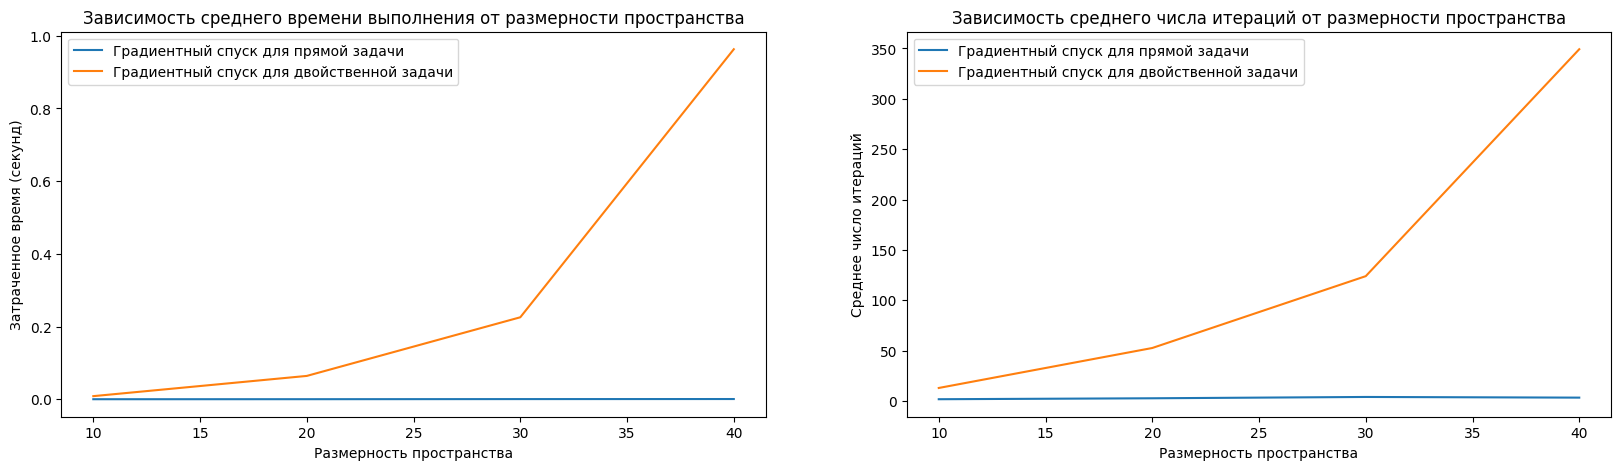

In [39]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

axes[0].plot(n, average_time_grad_prime, label=f"Градиентный спуск для прямой задачи") # построение графика на оси ax
axes[0].plot(n, average_time_grad_dual, label=f"Градиентный спуск для двойственной задачи") # построение графика на оси ax
axes[0].set_title("Зависимость среднего времени выполнения от размерности пространства") # название фигуры
axes[0].set_xlabel("Размерность пространства") # подпись по оси OX
axes[0].set_ylabel("Затраченное время (секунд)") # подпись по оси OY
axes[0].legend() # отображение подписей графиков

axes[1].plot(n, average_iterations_grad_prime, label=f"Градиентный спуск для прямой задачи") # построение графика на оси ax
axes[1].plot(n, average_iterations_grad_dual, label=f"Градиентный спуск для двойственной задачи") # построение графика на оси ax
axes[1].set_title("Зависимость среднего числа итераций от размерности пространства") # название фигуры
axes[1].set_xlabel("Размерность пространства") # подпись по оси OX
axes[1].set_ylabel("Среднее число итераций") # подпись по оси OY
axes[1].legend() # отображение подписей графиков

plt.show() # показ фигуры

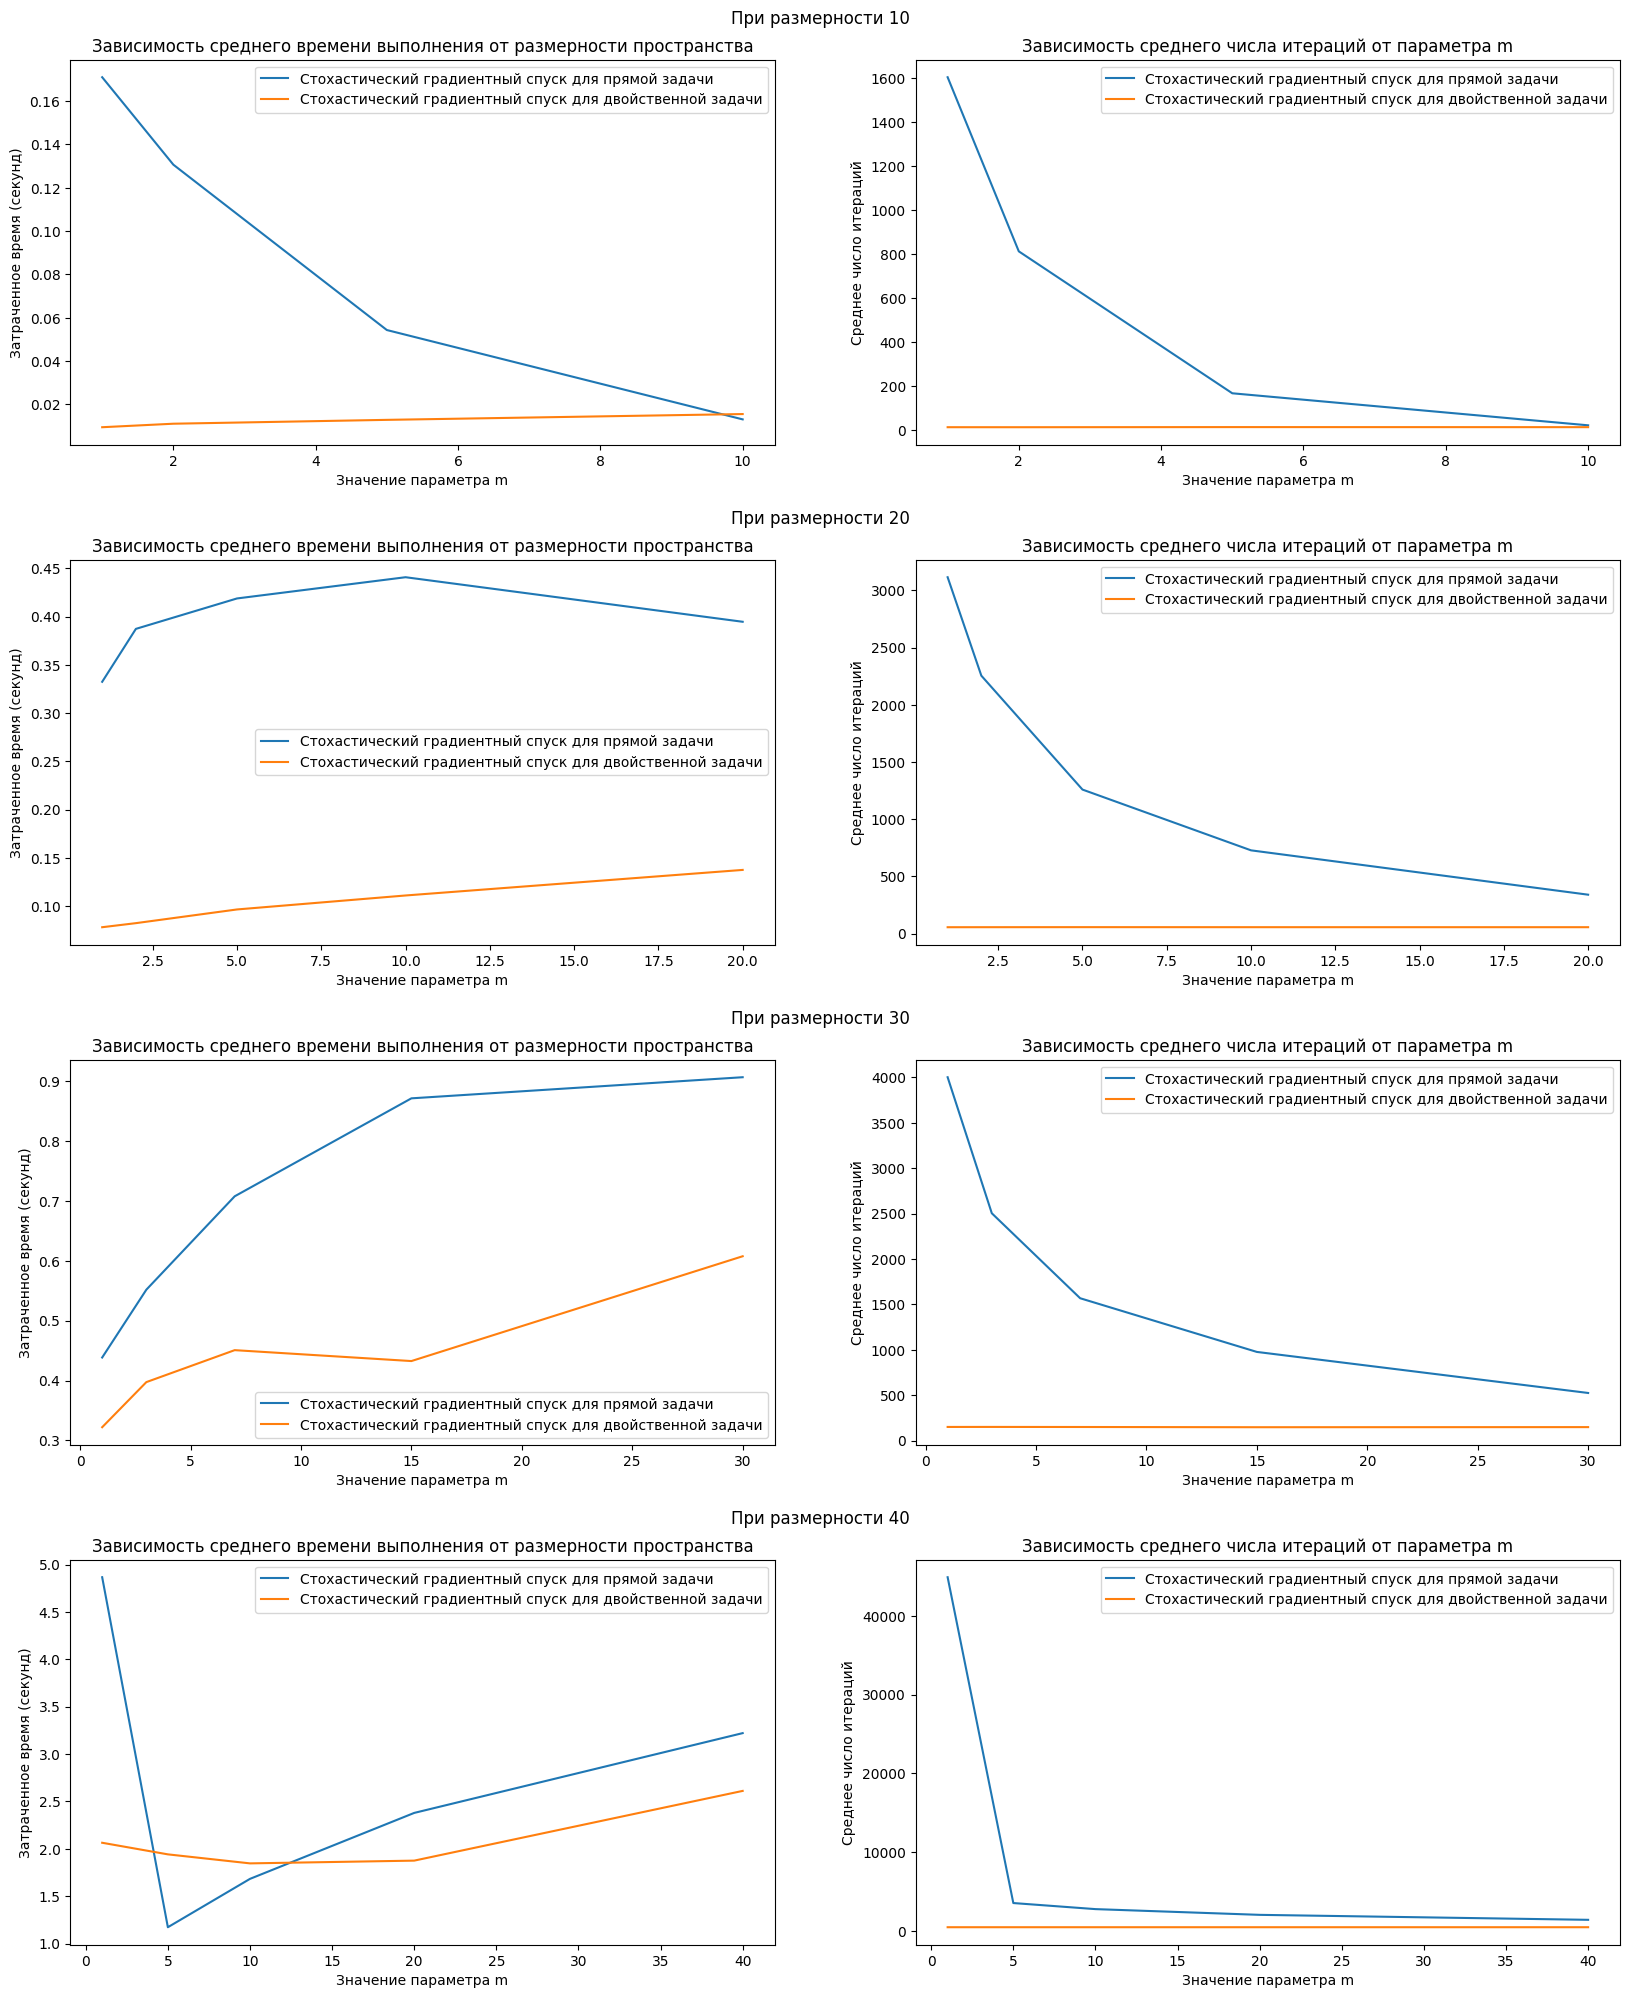

In [49]:
fig = plt.figure(figsize=(20, 20)) # создание фигуры размера figsize

subfigs = fig.subfigures(nrows=len(n), ncols=1) # создание подфигур (len(n) строк и всего один столбец)
for row, subfig in enumerate(subfigs):
    dim = n[row] # значение размерности на строке фигур
    m = sorted(set([1, int(dim/8), int(dim/4), int(dim/2), dim])) # значения параметра m для рассматриваемой размерности dim

    subfig.suptitle(f"При размерности {dim}") # добавление названия строке фигур
    axes = subfig.subplots(nrows=1, ncols=2) # создание двух подфигур в одной строке (из двух столбцов)

    axes[0].plot(m, average_time_stoh_grad_prime[dim], label=f"Стохастический градиентный спуск для прямой задачи") # построение графика на оси ax
    axes[0].plot(m, average_time_stoh_grad_dual[dim], label=f"Стохастический градиентный спуск для двойственной задачи") # построение графика на оси ax
    axes[0].set_title("Зависимость среднего времени выполнения от размерности пространства") # название фигуры
    axes[0].set_xlabel("Значение параметра m") # подпись по оси OX
    axes[0].set_ylabel("Затраченное время (секунд)") # подпись по оси OY
    axes[0].legend() # отображение подписей графиков

    axes[1].plot(m, average_iterations_stoh_grad_prime[dim], label=f"Стохастический градиентный спуск для прямой задачи") # построение графика на оси ax
    axes[1].plot(m, average_iterations_stoh_grad_dual[dim], label=f"Стохастический градиентный спуск для двойственной задачи") # построение графика на оси ax
    axes[1].set_title("Зависимость среднего числа итераций от параметра m") # название фигуры
    axes[1].set_xlabel("Значение параметра m") # подпись по оси OX
    axes[1].set_ylabel("Среднее число итераций") # подпись по оси OY
    axes[1].legend() # отображение подписей графиков

plt.show() # показ фигуры

Можно заметить:
* Стохастический градиентный спуск для двойственной задачи в разы лучше, чем для прямой. Данный факт связан с тем, что в двойственной задаче всего одна переменная, из-за чего метод стохастического градиента сводится к обычному.
* Чем больше значение параметра m, тем меньше итераций нужно стохастическому градиентному спуску в прямой задаче для приближения к оптимуму.
* Обычный градиентный спуск для прямой задачи сходится быстрее всего.

### Число арифметических операций

Если под арифметическими операциями понимать *операций с матрицами* (не учитывая их размерность, а под числами подразумевать матрицы 1x1), тогда для прямой задачи на одну итерацию градиентного спуска приходится $3+2+5+4=14$ арифметических операций:
* Подсчёт градиента $2A(x - μ)$: 
    * 1 (вычитание) + 2 (перемножение матриц) = 3
* Обновление текущей точки:
    * 1 (вычитание) + 1 (перемножение матриц) = 2
* Подсчёт нового значения функции $(x-μ)^T A (x-μ)$:
    * 2 (вычитание) + 1 (транспонирование) + 2 (перемножение матриц) = 5
* Проверка ограничения $x^T x ≤ 1$, обновление значения переменной, сравнение ответа с оптимумом: 
    * 1 (перемножение матриц) + 1 (сравнение) + 1 (обновление значения происходит почти всегда) + 1 (сравнение полученного ответа с оптимальным) = 4

Для двойственной при градиентном спуске $46+2+30+2=80$:
* Подсчёт градиента $-2((A+λE)^{-1}Aμ - μ)^T A ((A+λE)^{-2}Aμ) + (((A+λE)^{-1}Aμ)^T (A+λE)^{-1}Aμ - 1) - 2λ((A+λE)^{-1}Aμ)^T (A+λE)^{-2}Aμ$: 
    * 7 (сложение) + 3 (вычитание) + 3 (транспонирование) + 27 (перемножение матриц) + 6 (взятие обратной матрицы) = 46
* Обновление текущей точки:
    * 1 (сложение) + 1 (перемножение матриц) = 2
* Подсчёт нового значения функции $((A + λE)^{-1}Aμ-μ)^T A ((A + λE)^{-1}Aμ-μ) + λ(((A + λE)^{-1}Aμ)^T (A + λE)^{-1}Aμ - 1)$:
    * 5 (сложение) + 3 (вычитание) + 2 (транспонирование) + 16 (перемножение матриц) + 4 (взятие обратной матрицы) = 30
* Проверка ограничения $λ ≥ 0$, обновление значения переменной, сравнение ответа с оптимумом: 
    * 1 (сравнение) + 0 (ограничение почти никогда не нарушается) + 1 (сравнение полученного ответа с оптимальным) = 2
    
Для прямой при стохастическом градиентном спуске $m(3+2+1)+1+5+4=6m+10$: 
* Число подсчётов градиентов и обновления текущей точки увеличивается в $m$ раз(но само оно становится быстрее), при этом в нём добавляется одно умножение на $n$. В конце происходит деление на $m$.

Для двойственной в глобальном случае (если бы было несколько ограничений) при стохастическом градиентном спуске происходят те же изменения, что и в прямой $m(46+2+1)+1+30+2=49m+33$.

Для получения среднего числа арифметических операций данные коэффициенты нужно умножить на среднее число итераций в алгоритмах.

### Точность

Перепишем методы, чтобы из них можно было взять дополнительную информацию о близости к оптимальному результату.

In [68]:
accuracy = {} # словарь под точность ответов для различных начальных точек и методов

A = data[DIM][0]["A"] # матрица А для тест-кейса
μ = np.ones(shape=(DIM, 1)) # смещение центра функции, (dim, 1) — в виде столбца
constraint_center = np.zeros(shape=(DIM, 1)) # координаты центра сферы-ограничения задачи
res_solver = data[DIM][0]["Result solver"] # результат от солвера для тест-кейса

# считаем шаг для метода
eigenvalues = np.linalg.eigvals(A) # собственные значения матрицы A
α = 2 * eigenvalues.min() # параметр выпуклости функции, в данном случае равен 2 * минимальное собственное значение матрицы A
β = 2 * eigenvalues.max() # параметр гладкости функции, в данном случае равен 2 * максимальное собственное значение матрицы A
η = 2 / (α + β) # значение шага

In [70]:
start_points = [] # список под стартовые точки

for p in range(6): # идём по числу случайных стартовых точек
    # генерируем начальную точку при ограничение задачи — квадрат евклидовой нормы вектора x ≤ 1
    x = np.random.randint(low=0, high=100, size=(DIM, 1)) # генерируем случайные числа размера количества переменных (изначально они могут нарушать ограничения)
    x = x/np.linalg.norm(x, ord=2) # делим значение сгенерированного вектора на его евклидову норму, чтобы новая норма была точно ≤ 1 (на самом деле она будет лишь слегка меньше 1, но такая точка уже не нарушает ограничение задачи)
    start_points.append(x)

Градиентный спуск для сильно выпуклых и гладких функций. 

In [74]:
accuracy["grad"] = {} # словарь под значение Δ при разных начальных точках градиента

for p in range(6): # идём по числу случайных стартовых точек
    accuracy["grad"][p] = [] # список под значение Δ между оптимальным ответом и полученным на итерации

    x = start_points[p] # берём стартовую точку
    res_grad_primal = func_primal(x, A, μ) # значение начального решения метода градиентного спуска для рассматриваемой стартовой точки

    accuracy["grad"][p].append(abs(res_solver - res_grad_primal)) # запоминаем дельту (разницу ответа на старте итераций с оптимальным от солвера)

    while abs(res_solver - res_grad_primal) > ε: # пока не сошлись с ответом солвера
        x = x - η * func_primal_grad(x, A, μ) # обновляем значение x
        if dist(constraint_center, x) > 1: # если нарушили ограничение ~ вышли из допустимой области (Евклидово расстояние от нуля до точки должно быть <= 1)
            x = x / dist(constraint_center, x) # берём проекцию точки на dim-мерную сферу (делим координаты на расстояние до точки, чтобы новое расстояние было равно 1)
        res_grad_primal = func_primal(x, A, μ) # считаем значение функции

        accuracy["grad"][p].append(abs(res_solver - res_grad_primal)) # запоминаем дельту (разницу ответа на итерации с оптимальным от солвера)

Стохастический градиентный спуск.

In [75]:
for m in sorted(set([1, int(DIM/8), int(DIM/4), int(DIM/2), DIM])): # идём по отсортированным значениям m от меньшего к большему
    accuracy[f"stoh grad m={m}"] = {} # словарь под значение Δ при разных начальных точках стохастического градиента с параметром m

    for p in range(6): # идём по числу случайных стартовых точек
        accuracy[f"stoh grad m={m}"][p] = [] # список под значение Δ между оптимальным ответом и полученным на итерации

        x = start_points[p] # берём стартовую точку
        res_stoh_grad_primal = func_primal(x, A, μ) # значение начального решения метода градиентного спуска для рассматриваемой стартовой точки

        accuracy[f"stoh grad m={m}"][p].append(abs(res_solver - res_stoh_grad_primal)) # запоминаем дельту (разницу ответа на старте итераций с оптимальным от солвера)

        while abs(res_solver - res_stoh_grad_primal) > ε: # пока не сошлись с ответом солвера
            #========================= реализация через простую итерацию =================================
            grad = np.zeros(shape=(DIM, 1)) # "накопительный" вектор для градиента по компонентам
            for j in range(m): # делаем m выборов компоненты, по которой будет делать градиентный шаг
                i = np.random.randint(low=0, high=DIM, size=(1)) # случайным образом выбираем компоненту
                grad[i] += DIM * func_primal_grad(x, A[i], μ) # обновляем "накопительный" градиент только для выбранной i-ой компоненты
            grad = grad / m # усредняем по числу выбранных компонент
            #------------- умная реализация, в которой градиент считается один раз для всего -------------
            # grad = np.zeros(shape=(DIM, 1)) # "накопительный" вектор для градиента по компонентам
            # grad_full = func_primal_grad(x, A, μ) # значение градиента для всех компонент
            # j = np.random.randint(low=0, high=DIM, size=(m)) # случайным образом вибираем m компонент для шага
            # j = dict(zip(*np.unique(j, return_counts=True))) # конвертируем их в словарь вида "компонента: сколько раз по ней нужно проитерироваться"
            # for i in j.keys(): # идём по компонентам
            #     grad[i] += j[i] * DIM * grad_full[i] # обновляем "накопительный" градиент только для выбранной i-ой компоненты
            # grad = grad / m # усредняем по числу выбранных компонент
            #=============================================================================================

            x = x - η * grad # обновляем значение x (так как задача минимизации, то идём против градиента)
            if dist(constraint_center, x) > 1: # если нарушили ограничение ~ вышли из допустимой области (Евклидово расстояние от нуля до точки должно быть <= 1)
                x = x / dist(constraint_center, x) # берём проекцию точки на dim-мерную сферу (делим координаты на расстояние до точки, чтобы новое расстояние было равно 1)

            res_stoh_grad_primal = func_primal(x, A, μ) # считаем значение функции

            η = max(η * 0.999, 0.0001) # слегка уменьшаем шаг, но не меньше 0.0001
            accuracy[f"stoh grad m={m}"][p].append(abs(res_solver - res_stoh_grad_primal)) # запоминаем дельту (разницу ответа на итерации с оптимальным от солвера)

Точность сходимости разных методов.

In [78]:
m = sorted(set([1, int(DIM/8), int(DIM/4), int(DIM/2), DIM])) # значения параметра m стохастического градиентного спуска
m

[1, 2, 5, 10]

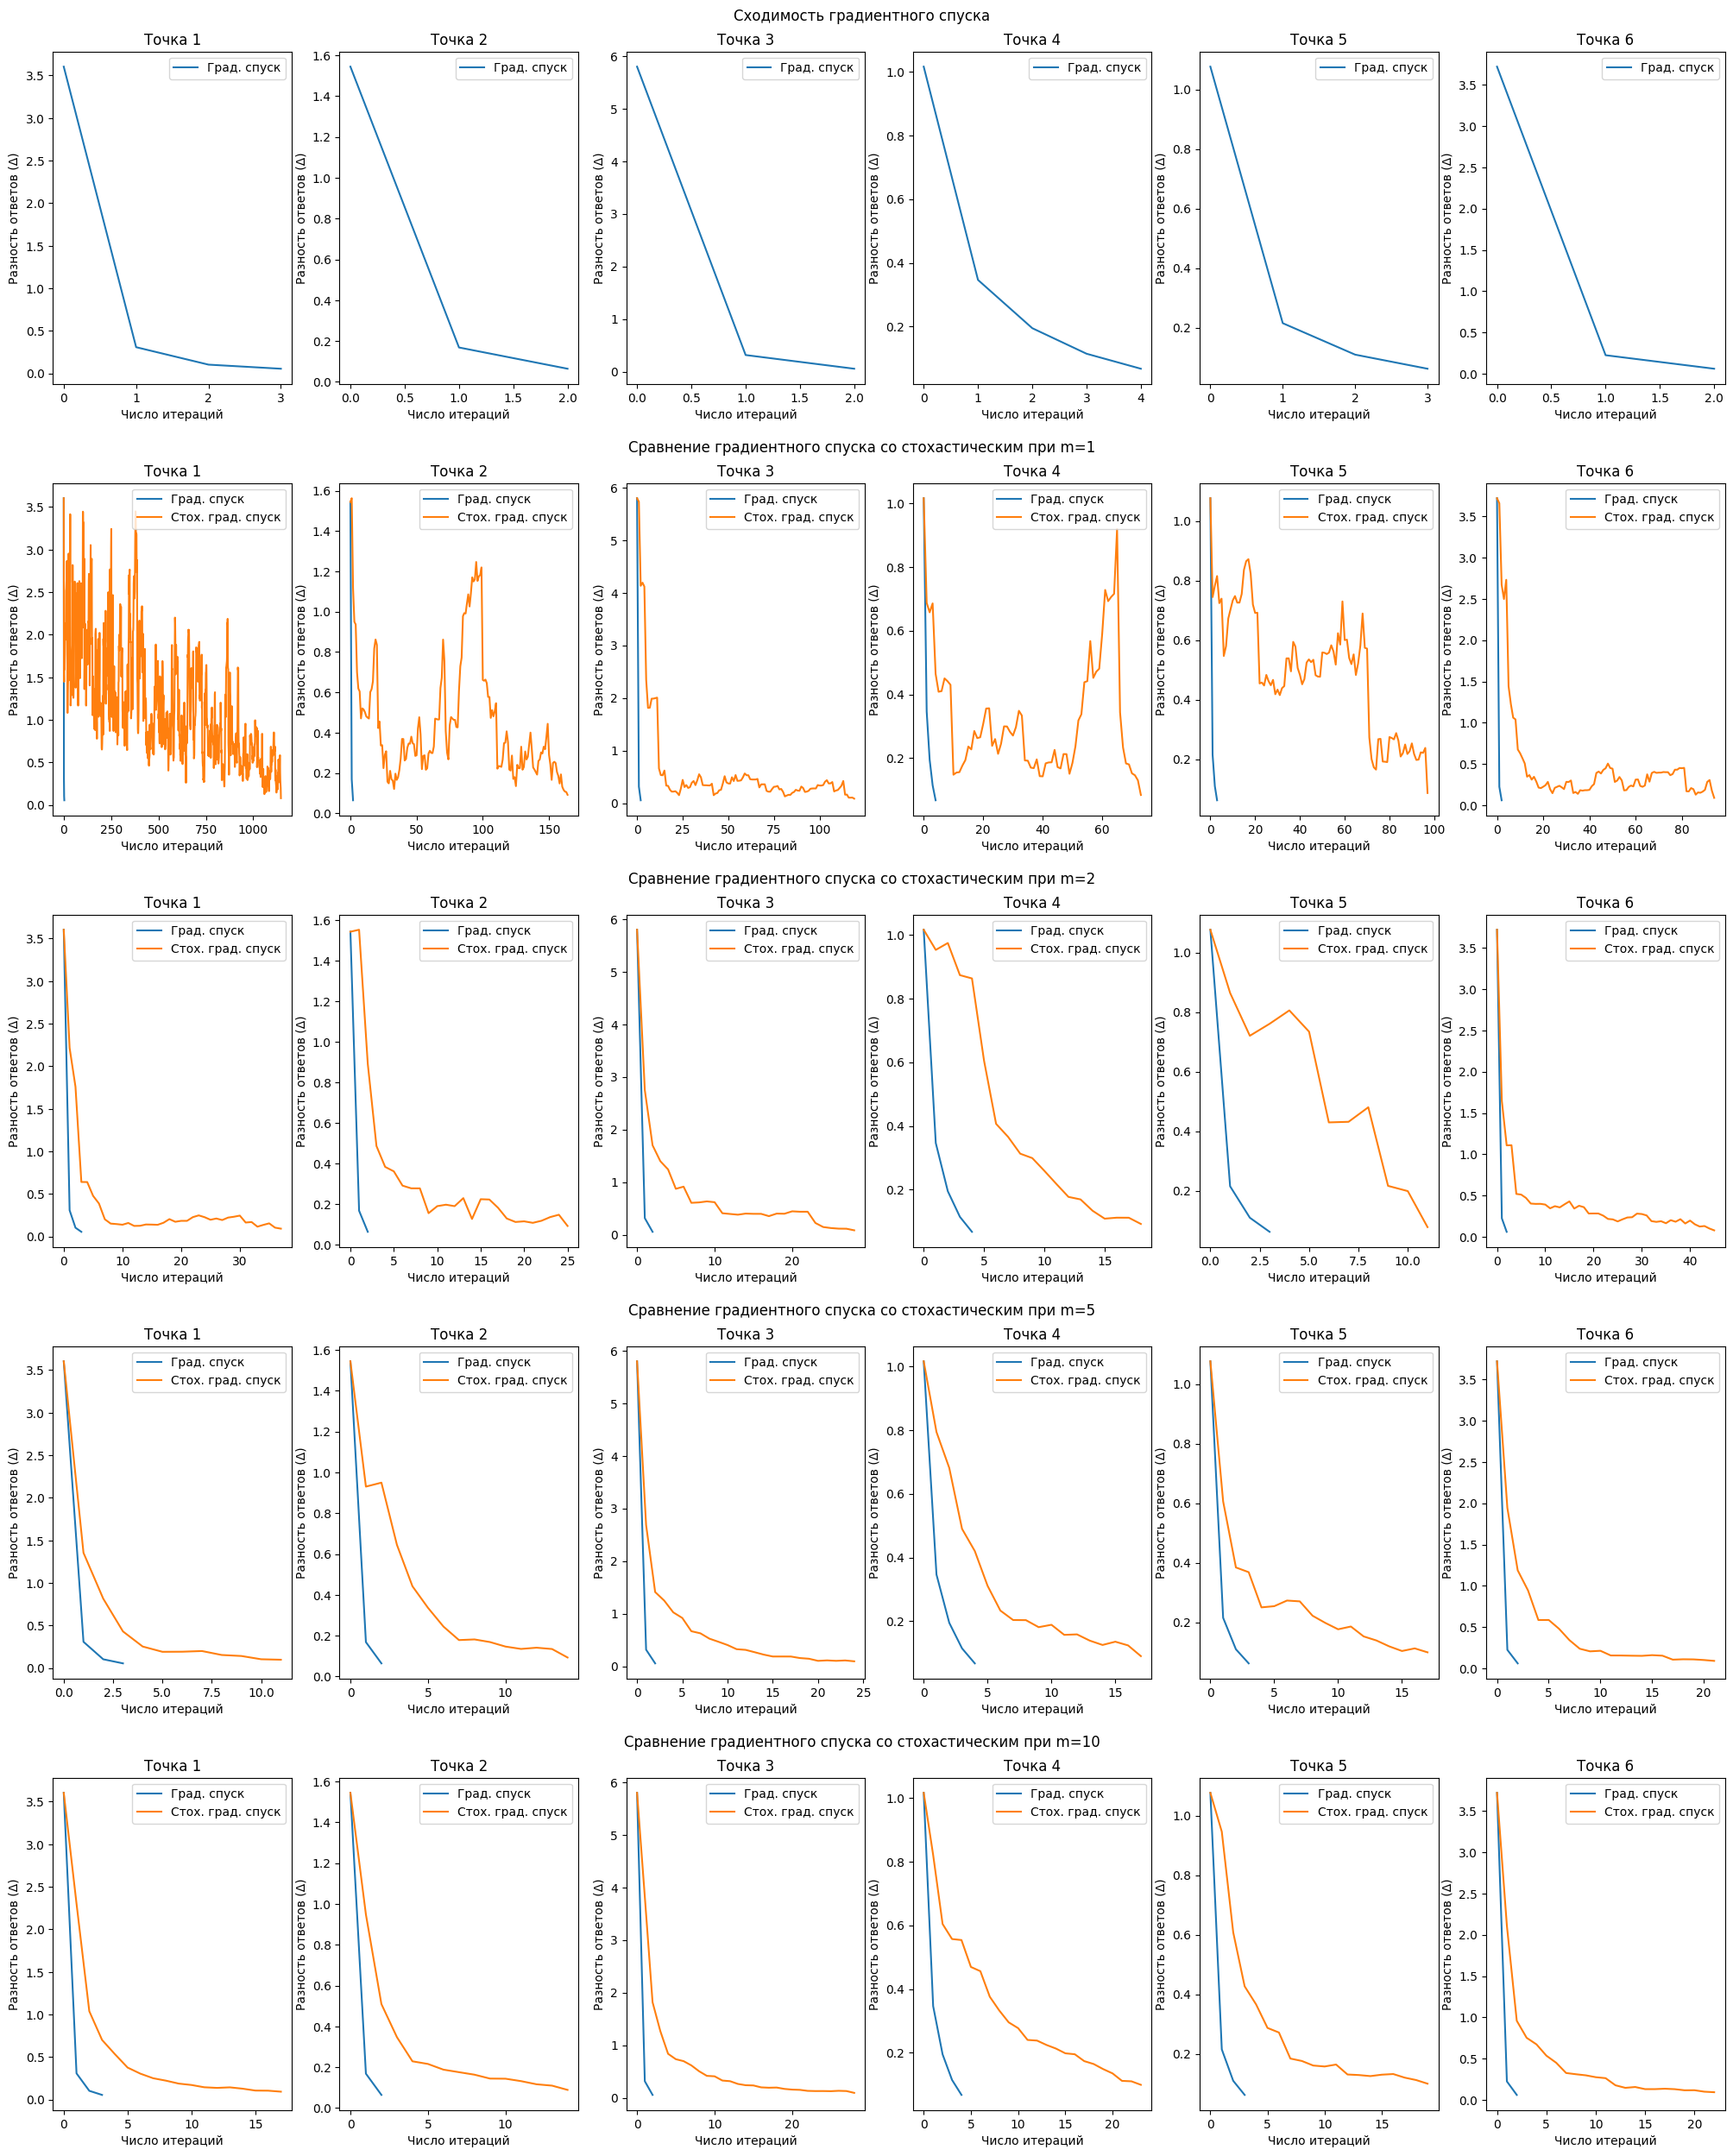

In [114]:
fig = plt.figure(figsize=(25, 25)) # создание фигуры размера figsize
subfigs = fig.subfigures(nrows=len(m)+1, ncols=1) # создание подфигур (len(n) строк и всего один столбец)

subfigs[0].suptitle(f"Сходимость градиентного спуска") # добавление названия строке фигур
axes = subfigs[0].subplots(nrows=1, ncols=6) # создание шести подфигур в одной строке (под точки)

for col in range(6): # идём по столбцам (точкам) фигуры-строки
    axes[col].plot(range(len(accuracy["grad"][col])), accuracy["grad"][col], label="Град. спуск") # построение графика на оси ax
    axes[col].set_title(f"Точка {col+1}") # название фигуры
    axes[col].set_xlabel("Число итераций") # подпись по оси OX
    axes[col].set_ylabel("Разность ответов (Δ)") # подпись по оси OY
    axes[col].legend() # отображение подписей графиков

for row, subfig in enumerate(subfigs[1:]): # идём по оставшимся строкам-подфигурам
    subfig.suptitle(f"Сравнение градиентного спуска со стохастическим при m={m[row]}") # добавление названия строке фигур
    axes = subfig.subplots(nrows=1, ncols=6) # создание шести подфигур в одной строке (под точки)

    for col in range(6): # идём по столбцам (точкам) фигуры-строки
        axes[col].plot(range(len(accuracy["grad"][col])), accuracy["grad"][col], label="Град. спуск") # построение графика на оси ax
        axes[col].plot(range(len(accuracy[f"stoh grad m={m[row]}"][col])), accuracy[f"stoh grad m={m[row]}"][col], label="Стох. град. спуск") # построение графика на оси ax
        axes[col].set_title(f"Точка {col+1}") # название фигуры
        axes[col].set_xlabel("Число итераций") # подпись по оси OX
        axes[col].set_ylabel("Разность ответов (Δ)") # подпись по оси OY
        axes[col].legend() # отображение подписей графиков
plt.show() # показ фигуры

Чем больше m — тем точнее сходится стохастический градиентный спуск.